Testing normalization with units in a compound model setting. 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2764721413020682
            Iterations: 141
            Function evaluations: 1058
            Gradient evaluations: 141
Optimization terminated successfully.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.32582717533902
            Iterations: 61
            Function evaluations: 458
            Gradient evaluations: 61
Optimization terminated successfully.


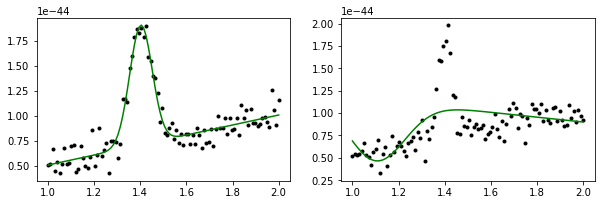

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.gcf().set_size_inches(8.,4.)

from astropy import units as u
from astropy.modeling import models, fitting

def perform_fit(model, wave, flux):
    # Set up fitter
    slsqp_fitter = fitting.SLSQPLSQFitter()

    # Define custom units for x and y
    ux1 = u.def_unit('ux1')
    uy1 = u.def_unit('uy1')
    w1 = wave * ux1
    f1 = flux * uy1

    # Determine maximum values in each direction
    wmax = np.max(np.abs(w1.value))
    fmax = np.max(np.abs(f1.value))

    # Define new units so that in this system, the data is always in the range
    # [-1:1] in both directions and convert data to that frame.
    ux2 = u.Unit(wmax * w1.unit)
    uy2 = u.Unit(fmax * f1.unit)
    w2 = w1.to(ux2)
    f2 = f1.to(uy2)

    # Strip away the units for the fitting
    w3 = w2.value
    f3 = f2.value

    # Run the fitting
    g3_new = slsqp_fitter(model, w3, f3, maxiter=1000)

    print(slsqp_fitter.fit_info['message'])

    # Add units to the parameters for the data that was fit, and then transform
    # the parameters to the original units of the data
    g2_new = g3_new.with_units_from_data(x=w2, y=f2)
    g1_new = g2_new.without_units_for_data(x=w1, y=f1)

    return g1_new

# Scale flux to realistic values in flam
SCALE = 1e-44

# Simulated Gaussian + linear. Gaussians differ slightly in width.
w1 = np.linspace(1, 2, 100)
f1 = (1.2 * SCALE * np.exp(-0.5 * (w1 - 1.4)**2 / 0.05**2) +
      SCALE * (0.01 + 0.5 * w1) + 
      SCALE / 10 * np.random.normal(0, 1, len(w1)))
f2 = (1.2 * SCALE * np.exp(-0.5 * (w1 - 1.4)**2 / 0.03**2) +
      SCALE * (0.01 + 0.5 * w1) + 
      SCALE / 10 * np.random.normal(0, 1, len(w1)))

model = models.Gaussian1D() + models.Linear1D()

result_1 = perform_fit(model, w1, f1)
result_2 = perform_fit(model, w1, f2)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(w1, f1, 'k.')
plt.plot(w1, result_1(w1), 'g-')
plt.subplot(122)
plt.plot(w1, f2, 'k.')
plt.plot(w1, result_2(w1), 'g-')